In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

sns.set()

In [2]:
df = pd.read_csv('../data/raw/training_v2.csv')

In [3]:
# drop readmission_status as it has all 0
df.drop('readmission_status', axis=1, inplace=True)

# drop columns with id (don't have an influence on the model)
df.drop('encounter_id', axis=1, inplace=True)
df.drop('patient_id', axis=1, inplace=True)
df.drop('hospital_id', axis=1, inplace=True)
df.drop('icu_id', axis=1, inplace=True)

In [4]:
def preprocess_object_features(df):   
    df['gender'] = df['gender'].fillna(df['gender'].value_counts().index[0])
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})

    df['ethnicity'] = df['ethnicity'].fillna("Other/Unknown")

    df['hospital_admit_source'] = df['hospital_admit_source'].fillna("Other")
    
    df['icu_stay_type'] = df['icu_stay_type'].fillna(df['icu_stay_type'].value_counts().index[0])
    df['icu_stay_type'] = df['icu_stay_type'].map({'admit': 0, 'transfer': 1})
    
    # remove outliers
    df = df[df["pre_icu_los_days"] < 88]
    df["pre_icu_los_days"] = np.maximum(0, df["pre_icu_los_days"])
    
    und_diag = {"Undefined diagnoses": "Undefined Diagnoses"}
    df["apache_2_bodysystem"].replace(und_diag, inplace = True)

    cat_columns = ["ethnicity", 
                   "hospital_admit_source",
                   "icu_admit_source", 
                   "icu_type",
                   "apache_3j_bodysystem", 
                   "apache_2_bodysystem"]

    df = pd.get_dummies(df, columns=cat_columns)
    
    return df

In [5]:
def evaluate(y_true, scores, preds):
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    
    roc_auc = roc_auc_score(y_true, scores)
    auprc = average_precision_score(y_true, scores)
    
    print("Accuracy:  {:.3f}".format(acc))
    print("Precision: {:.3f}".format(precision))
    print("Recall:    {:.3f}".format(recall))
    print("F1-score:  {:.3f}".format(f1))
    print("ROCAUC:    {:.3f}".format(roc_auc))
    print("AUPRC:     {:.3f}".format(auprc))

In [6]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [27]:
def plot_precision_recall_curve(y_test, probs):
    precision, recall, threshold = precision_recall_curve(y_test, probs)
    auc_score = auc(recall, precision)
    
    plt.title('2-class Precision-Recall curve')
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.plot(recall, precision, 'r', marker='.')
    plt.show()

In [8]:
clean_df = preprocess_object_features(df)

In [9]:
y = clean_df.hospital_death
X = clean_df.drop(columns="hospital_death")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [10]:
import xgboost as xgb
from xgboost import plot_importance

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(n_estimators=128,
                          learning_rate=0.1,
                          max_depth=6,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          subsample=1,
                          random_state=42,
                          scale_pos_weight=scale_pos_weight,
                          n_jobs=-1)

model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=128, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=10.58721478408448, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [11]:
y_true = y_test.values

y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.858
Precision: 0.346
Recall:    0.730
F1-score:  0.470
ROCAUC:    0.896
AUPRC:     0.558


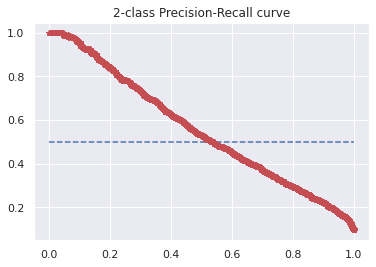

In [26]:
plot_precision_recall_curve(y_true, y_score[:, 1])

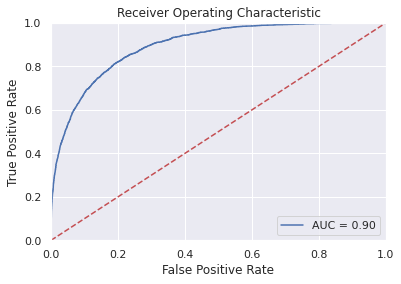

In [13]:
plot_roc_curve(y_true, y_score[:, 1])

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


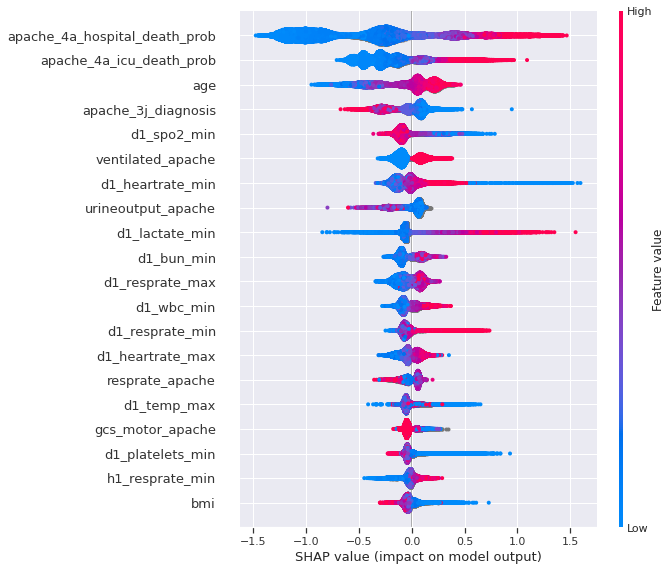

In [15]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)
f.savefig("../reports/2.0_xgboost_summary_plot.png", bbox_inches='tight', dpi=600)

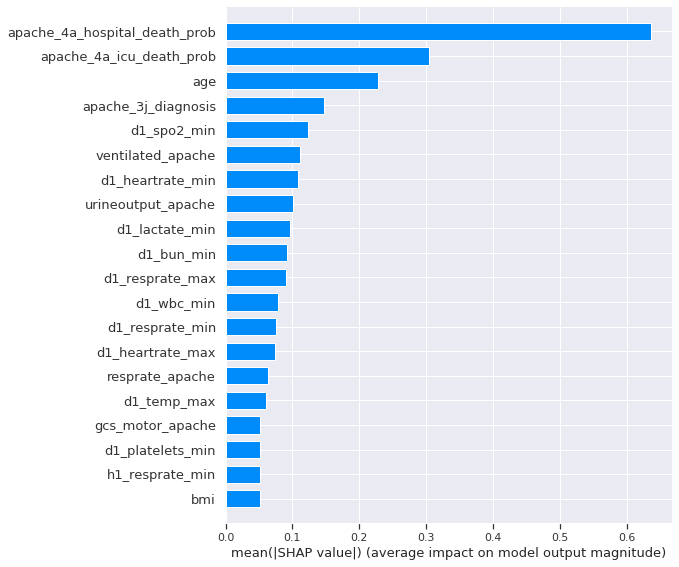

In [16]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

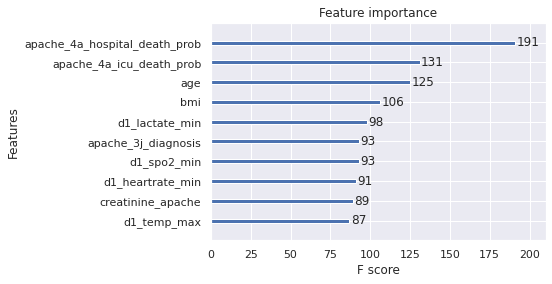

In [17]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)
plt.show()